# Setup

In [1]:
import os
import time

import numpy as np
import scipy.io as sio
import spectral
from sklearn import cluster
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, adjusted_rand_score
from tensorflow import keras

def applyPCA(X, numComponents=75):
    xshape = X.shape
    pca = PCA(n_components=numComponents, whiten=True)
    PCs = pca.fit_transform(X.reshape(-1, xshape[2])).reshape(xshape[0], xshape[1], numComponents)
    return PCs

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2*margin, X.shape[1] + 2*margin, X.shape[2]))
    newX[margin:X.shape[0] + margin, margin:X.shape[1] + margin, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def count_FLOPs(model):
    '''FLOPs的计算：    
    参考https://www.zhihu.com/question/65305385
    以及https://blog.csdn.net/weixin_43915709/article/details/94566125
    '''
    FLOPs = 0
    for i in range(len(model.layers)):
        layer = model.layers[i]
        if layer.__class__.__name__ == 'Conv3D':
            FLOPs += 2*np.prod(layer.kernel_size[:3])*np.prod(layer.output_shape[1:5])
        if layer.__class__.__name__ == 'Conv2D':
            FLOPs += 2*np.prod(layer.kernel_size[:2])*layer.input_shape[3]*np.prod(layer.output_shape[1:4])
        if layer.__class__.__name__ in ('MaxPooling3D', 'AveragePooling3D'):
            FLOPs += np.prod(layer.pool_size[:3])*np.prod(layer.output_shape[1:5])
        if layer.__class__.__name__ in ('MaxPooling2D', 'AveragePooling2D'):
            FLOPs += np.prod(layer.pool_size[:2])*np.prod(layer.output_shape[1:4])
        if layer.__class__.__name__ == 'GlobalAveragePooling3D':
            FLOPs += np.prod(layer.input_shape[1:5])
        if layer.__class__.__name__ == 'GlobalAveragePooling2D':
            FLOPs += np.prod(layer.input_shape[1:4])             
        if layer.__class__.__name__ in ('Activation', 'Add', 'Multiply'):
            FLOPs += np.prod(layer.output_shape[1:])            
        if layer.__class__.__name__ == 'Dense':
            FLOPs += 2*layer.input_shape[1]*layer.output_shape[1]
        #if layer.__class__.__name__ == 'BatchNormalization':               
    return FLOPs

HSI = sio.loadmat(os.path.join(os.getcwd(),'data/PaviaU.mat'))['paviaU']
GT = sio.loadmat(os.path.join(os.getcwd(),'data/PaviaU_gt.mat'))['paviaU_gt']
test_ratio = 0.9

# Visualization

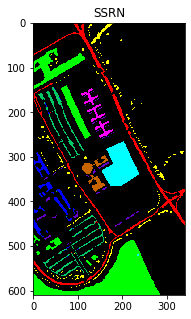

In [14]:
# original images
#view=spectral.imshow(HSI, (53, 31, 8), figsize=(5, 5), classes=GT, title='Pavia University')

# lulc maps
predictions = np.argmax(model.predict(X), axis=1)+1
outputs = np.zeros(GT.shape)
k = 0
for i in range(GT.shape[0]):
    for j in range(GT.shape[1]):
        if int(GT[i,j]) == 0 :
            continue
        else:
            outputs[i, j] = predictions[k]
            k += 1
            
#ground_truth = spectral.imshow(classes = GT,figsize =(5,5), title='Ground Truth')
#spectral.save_rgb(str(dataset)+"_ground_truth.jpg", GT, colors=spectral.spy_colors)
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5), title='SSRN')
#spectral.save_rgb(str(dataset)+"_ClusterCNN_"+expnum+".jpg", outputs.astype(int), colors=spectral.spy_colors)

# DCCNN
https://github.com/stop68/Remote-Sensing-Image-Classification/blob/master/demo_keras.py

In [6]:
from Utils import networks as nw

patch = 5  # if patch==5, WCRN DCCNN. if patch==7, BDMA.
im = applyPCA(HSI,numComponents=15)
im1x,im1y,im1z = im.shape
cls1 = np.max(GT)

X, y = createImageCubes(im, GT, windowSize=patch)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=345, stratify=y)
# x_train,y_train = rscls.make_sample(x_train,y_train)  # augmentation
y_train = keras.utils.to_categorical(np.asarray(y_train))

# DBMA
model = nw.DCCNN(im1z, patch, cls1) 
adadelta1 = keras.optimizers.Adadelta(lr=1.0)
adadelta2 = keras.optimizers.Adadelta(lr=0.2)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=2)

for i in range(1):
    time1 = int(time.time())
    # first train the model with lr=1.0    
    model.compile(loss='categorical_crossentropy',optimizer=adadelta1,metrics=['accuracy'])
    model.fit(x_train,y_train,batch_size=20,epochs=80,verbose=0,shuffle=True)

    # then train the model with lr=0.1; if loss not decrease for 5 epoches, stop training
    model.compile(loss='categorical_crossentropy',optimizer=adadelta2,metrics=['accuracy'])   
    model.fit(x_train,y_train,batch_size=20,epochs=20,verbose=0,shuffle=0,callbacks=[early_stopping])
    time2 = int(time.time())

    # predict
    y_pred = np.argmax(model.predict(x_test), axis=1)
    oa = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    print('DBMA:', oa, kappa, ' Time Comsumption:', time2-time1)

Epoch 00007: early stopping
DBMA: 0.9857398893477752 0.9811037280460545  Time Comsumption: 365


# DBMA
https://github.com/stop68/Remote-Sensing-Image-Classification/blob/master/demo_keras.py

In [11]:
from Utils import networks as nw

patch = 7  # if patch==5, WCRN DCCNN. if patch==7, BDMA. if patch==9, ResNet-avg.
im = applyPCA(HSI,numComponents=15)
im1x,im1y,im1z = im.shape
cls1 = np.max(GT)

X, y = createImageCubes(im, GT, windowSize=patch)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], X.shape[3], -1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=345, stratify=y)
# x_train,y_train = rscls.make_sample(x_train,y_train)  # augmentation
y_train = keras.utils.to_categorical(np.asarray(y_train))
#x_train = x_train.reshape(x_train.shape[0],patch,patch,im1z,-1) # 3D CNN, samples are 5-dimensional
#x_test = x_test.reshape(x_test.shape[0],patch,patch,im1z,-1)    # 3D CNN, samples are 5-dimensional

# DBMA
model = nw.DBMA(im1z, patch, cls1)  # 3D CNN, samples are 5-dimensional
adadelta1 = keras.optimizers.Adadelta(lr=1.0)
adadelta2 = keras.optimizers.Adadelta(lr=0.2)
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=2)

for i in range(1):
    time1 = int(time.time())
    # first train the model with lr=1.0    
    model.compile(loss='categorical_crossentropy',optimizer=adadelta1,metrics=['accuracy'])
    model.fit(x_train,y_train,batch_size=20,epochs=80,verbose=0,shuffle=True)

    # then train the model with lr=0.1; if loss not decrease for 5 epoches, stop training
    model.compile(loss='categorical_crossentropy',optimizer=adadelta2,metrics=['accuracy'])   
    model.fit(x_train,y_train,batch_size=20,epochs=20,verbose=0,shuffle=0,callbacks=[early_stopping])
    time2 = int(time.time())

    # predict
    y_pred = np.argmax(model.predict(x_test), axis=1)
    oa = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    print('DBMA:', oa, kappa, ' Time Comsumption:', time2-time1)

DBMA: 0.9986233408659965 0.9981756948205219  Time Comsumption: 562


# SSRN
https://github.com/zilongzhong/SSRN

In [ ]:
from Utils import ssrn_SS_IN

patch = 7  #25
nb_classes = np.max(GT)

data_norm = HSI.reshape(np.prod(HSI.shape[:2]),np.prod(HSI.shape[2:]))
data_norm = scale(data_norm)
data_norm = data_norm.reshape(HSI.shape[0], HSI.shape[1],HSI.shape[2])
#im = applyPCA(data_norm,numComponents=15)
im = data_norm

X, y = createImageCubes(im, GT, windowSize=patch)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], X.shape[3], 1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=345, stratify=y)
y_train = keras.utils.to_categorical(np.asarray(y_train))
VAL_SIZE = int(0.1*X.shape[0])
x_val = x_test[-VAL_SIZE:]
y_val = keras.utils.to_categorical(np.asarray(y_test))[-VAL_SIZE:]
x_test = x_test[:-VAL_SIZE]
y_test = y_test[:-VAL_SIZE]

# SSRN 4 with BN
model = ssrn_SS_IN.ResnetBuilder.build_resnet_8((1, patch, patch, im.shape[2]), nb_classes)
RMS = keras.optimizers.RMSprop(lr=0.0003)
model.compile(loss='categorical_crossentropy', optimizer=RMS, metrics=['accuracy'])

#x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3], 1)
#x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], x_val.shape[3], 1)
#x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], x_test.shape[3], 1)

for i in range(1):
    time1 = int(time.time())
    # training
    model.fit(x_train, y_train, batch_size=16, epochs=100, shuffle=False, verbose=0)
    time2 = int(time.time())
    
    # predict
    y_pred = np.argmax(model.predict(x_test), axis=1)
    oa = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    print('SSRN:', oa, kappa, ' Time Comsumption:', time2-time1)

# HybridSN
https://github.com/gokriznastic/HybridSN

In [6]:
windowSize = 25
PCsNum = 15
HPCs = applyPCA(HSI,numComponents=PCsNum)

X, y = createImageCubes(HPCs, GT, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, PCsNum, 1)
Xtest = Xtest.reshape(-1, windowSize, windowSize, PCsNum, 1)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
input_layer = keras.Input((windowSize, windowSize, PCsNum, 1))

## convolutional layers
conv_layer1 = keras.layers.Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = keras.layers.Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = keras.layers.Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
conv3d_shape = conv_layer3.shape
conv_layer3 = keras.layers.Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = keras.layers.Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = keras.layers.Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = keras.layers.Dropout(0.4)(dense_layer1)
dense_layer2 = keras.layers.Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = keras.layers.Dropout(0.4)(dense_layer2)
output_layer = keras.layers.Dense(units=ytrain.shape[1], activation='softmax')(dense_layer2)

model = keras.models.Model(inputs=input_layer, outputs=output_layer, name='HybridSN')
        
# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

for j in range(1):
    time1 = int(time.time())
    # training
    model.fit(x=Xtrain, y=ytrain, batch_size=128, epochs=100, verbose=0)     
    time2 = int(time.time())
    
    # predict
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa = accuracy_score(ytest, y_pred)
    kappa = cohen_kappa_score(ytest, y_pred)

    print('Hybrid:', oa, kappa, ' Time Comsumption:', time2-time1)

Hybrid: 0.984467129016338 0.9794220770793202  Time Comsumption: 375


# ClusterCNN

## vanilla ClusterCNN

In [4]:
patch = 25
PCsNum = 15
ClusterNum = 100   
HPCs = applyPCA(HSI,numComponents=PCsNum)

start_time = time.process_time()
clusterstack = np.zeros(HPCs.shape)
cluster_algorithm = 'minikmeans' 

mbk_means = cluster.MiniBatchKMeans(n_clusters=ClusterNum).fit(HPCs.reshape((-1, HPCs.shape[2])))
clusterlabel = mbk_means.labels_.reshape((GT.shape))
for i in range(ClusterNum):
    clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)
    
timeused = (time.process_time() - start_time)
print(f'{cluster_algorithm}.  Clustering Time:{timeused}s.  # of Clusters:{np.max(clusterlabel)+1}')

X, y = createImageCubes(clusterstack, GT, windowSize=patch)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(patch, patch, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
P1 = keras.layers.MaxPool2D()(C1)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(P1) 
P2 = keras.layers.MaxPool2D()(C2)
## flatten
FL = keras.layers.Flatten(name='FL')(P2)        
## fully connected layers
D1 = keras.layers.Dense(units=128, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=64, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)
        
model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

for j in range(1):
    time3 = int(time.time())
    # training
    model.fit(x=Xtrain, y=ytrain, batch_size=64, epochs=100, verbose=0)
    time4 = int(time.time())
    
    # predic
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa = accuracy_score(ytest, y_pred)
    kappa = cohen_kappa_score(ytest, y_pred)

    print('ClusterCNN:', oa, kappa, ' Training Time:', time4-time3)

Shape of Clusters: (610, 340, 15) Clustering Time:  7.15625 s.  # of Clusters: 100
ClusterCNN: 0.9974804540377672 0.9966613864840083  Training Time: 42


## ClusterCNN with very few Clusters

In [2]:
patch = 25
PCsNum = 15
ClusterNum = 20    
HPCs = applyPCA(HSI,numComponents=PCsNum)

start_time = time.process_time()
clusterstack = np.zeros(HPCs.shape)

cluster_algorithm = 'minibatchKmeans'
mbk_means = cluster.MiniBatchKMeans(n_clusters=ClusterNum).fit(HPCs.reshape((-1, HPCs.shape[2])))
clusterlabel = mbk_means.labels_.reshape((GT.shape))
for i in range(ClusterNum):
    clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)

timeused = (time.process_time() - start_time)
print(f'{cluster_algorithm}.  Clustering Time:{timeused}s.  # of Clusters:{np.max(clusterlabel)+1}')

X, y = createImageCubes(clusterstack, GT, windowSize=patch)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(patch, patch, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
P1 = keras.layers.MaxPool2D()(C1)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(P1) 
P2 = keras.layers.MaxPool2D()(C2)
## flatten
FL = keras.layers.Flatten(name='FL')(P2)        
## fully connected layers
D1 = keras.layers.Dense(units=128, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=64, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)

model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')

# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

start_time = time.process_time()
# training
model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, verbose=0)
training_time = time.process_time()-start_time

# predict
y_pred = np.argmax(model.predict(Xtest), axis=1)
oa = accuracy_score(ytest, y_pred)
kappa = cohen_kappa_score(ytest, y_pred)

print('ClusterCNN:', oa, kappa, ' Training Time:', training_time)

minibatchKmeans.  Clustering Time:1.390625s.  # of Clusters:20
ClusterCNN: 0.9955583261902906 0.9941154674703562  Training Time: 119.9375


## ClusterCNN with DBSCAN

In [ ]:
patch = 25
PCsNum = 15  
HPCs = applyPCA(HSI,numComponents=PCsNum)

start_time = time.process_time()
clusterstack = np.zeros(HPCs.shape)

cluster_algorithm = 'density' 
dbcluster = cluster.DBSCAN().fit(HPCs[:,:,:3].reshape((-1, 3)))
clusterlabel = dbcluster.labels_.reshape((GT.shape))

for i in range(np.max(clusterlabel)+1):
    clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)
    
timeused = (time.process_time() - start_time)
print(f'{cluster_algorithm}.  Clustering Time:{timeused}s.  # of Clusters:{np.max(clusterlabel)+1}')
    
X, y = createImageCubes(clusterstack, GT, windowSize=patch)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(patch, patch, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
P1 = keras.layers.MaxPool2D()(C1)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(P1) 
P2 = keras.layers.MaxPool2D()(C2)
## flatten
FL = keras.layers.Flatten(name='FL')(P2)        
## fully connected layers
D1 = keras.layers.Dense(units=128, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=64, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)
        
model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

for j in range(1):
    time3 = int(time.time())
    # training
    model.fit(x=Xtrain, y=ytrain, batch_size=64, epochs=100, verbose=0)
    time4 = int(time.time())
    
    # predic
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa = accuracy_score(ytest, y_pred)
    kappa = cohen_kappa_score(ytest, y_pred)

    print('ClusterCNN:', oa, kappa, ' Training Time:', time4-time3)

## ClusterCNN with Spectral Clustering

In [8]:
patch = 25
PCsNum = 15
ClusterNum = 20   
HPCs = applyPCA(HSI,numComponents=PCsNum)

start_time = time.process_time()
clusterstack = np.zeros(HPCs.shape)

cluster_algorithm = 'spectral'
specluster = cluster.SpectralClustering(n_clusters=ClusterNum).fit(HPCs.reshape((-1, HPCs.shape[2])))
clusterlabel = specluster.labels_.reshape((GT.shape))
for i in range(ClusterNum):
    clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)
    
timeused = (time.process_time() - start_time)
print(f'{cluster_algorithm}.  Clustering Time:{timeused}s.  # of Clusters:{np.max(clusterlabel)+1}')
    
X, y = createImageCubes(clusterstack, GT, windowSize=patch)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(patch, patch, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
P1 = keras.layers.MaxPool2D()(C1)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(P1) 
P2 = keras.layers.MaxPool2D()(C2)
## flatten
FL = keras.layers.Flatten(name='FL')(P2)        
## fully connected layers
D1 = keras.layers.Dense(units=128, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=64, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)
        
model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

for j in range(1):
    time3 = int(time.time())
    # training
    model.fit(x=Xtrain, y=ytrain, batch_size=64, epochs=100, verbose=0)
    time4 = int(time.time())
    
    # predic
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa = accuracy_score(ytest, y_pred)
    kappa = cohen_kappa_score(ytest, y_pred)

    print('ClusterCNN:', oa, kappa, ' Training Time:', time4-time3)

MemoryError: Unable to allocate array with shape (207400, 207400) and data type float64

## ClusterCNN without Clustering

In [2]:
patch = 25
PCsNum = 15
HPCs = applyPCA(HSI,numComponents=PCsNum)

clusterstack = HPCs
    
X, y = createImageCubes(clusterstack, GT, windowSize=patch)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(patch, patch, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
P1 = keras.layers.MaxPool2D()(C1)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(P1) 
P2 = keras.layers.MaxPool2D()(C2)
## flatten
FL = keras.layers.Flatten(name='FL')(P2)        
## fully connected layers
D1 = keras.layers.Dense(units=128, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=64, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)
        
model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

for j in range(1):
    time3 = int(time.time())
    # training
    model.fit(x=Xtrain, y=ytrain, batch_size=64, epochs=100, verbose=0)
    time4 = int(time.time())
    
    # predic
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa = accuracy_score(ytest, y_pred)
    kappa = cohen_kappa_score(ytest, y_pred)

    print('Just CNN:', oa, kappa, ' Training Time:', time4-time3)

Just CNN: 0.9985713914647134 0.9981068585319672  Training Time: 86


## ClusterCNN with 1ofK Clustering Expression

In [2]:
patch = 25
PCsNum = 15
ClusterNum = 15    
HPCs = applyPCA(HSI,numComponents=PCsNum)

start_time = time.process_time()

cluster_algorithm = 'minibatchKmeans'
mbk_means = cluster.MiniBatchKMeans(n_clusters=ClusterNum).fit(HPCs.reshape((-1, HPCs.shape[2])))
clusterlabel = mbk_means.labels_.reshape((GT.shape))
clusterstack = keras.utils.to_categorical(clusterlabel) 
timeused = (time.process_time() - start_time)
print(cluster_algorithm, 'Clustering Time: ', timeused, 's.  # of Clusters:', np.max(clusterlabel)+1)

X, y = createImageCubes(clusterstack, GT, windowSize=patch)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(patch, patch, ClusterNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
P1 = keras.layers.MaxPool2D()(C1)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(P1) 
P2 = keras.layers.MaxPool2D()(C2)
## flatten
FL = keras.layers.Flatten(name='FL')(P2)        
## fully connected layers
D1 = keras.layers.Dense(units=128, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=64, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)

model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')

# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

start_time = time.process_time()
# training
model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, verbose=0)
training_time = time.process_time()-start_time

# predict
y_pred = np.argmax(model.predict(Xtest), axis=1)
oa = accuracy_score(ytest, y_pred)
kappa = cohen_kappa_score(ytest, y_pred)

print('ClusterCNN:', oa, kappa, ' Training Time:', training_time)

minibatchKmeans Clustering Time:  1.578125 s.  # of Clusters: 15
ClusterCNN: 0.9963375672095379 0.9951479675667266  Training Time: 103.640625


# UnmixingCNN

A Python3 library for basic unmixing functions: https://github.com/etienne-monier/lib-unmixing  
Robust-NMF: https://github.com/neel-dey/robust-nmf  
ELMM & social norms: https://github.com/ldrumetz

In [ ]:
# 基于pytorch的unmixing
import torch
from LibUnmixing import rnmf_torch

patch = 25
PCsNum = 15
HPCs = applyPCA(HSI,numComponents=PCsNum)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HPCs = torch.from_numpy(HPCs*0.05 + 6).float().to(device)
_, coeff, _, _ = rnmf_numpy.robust_nmf(data=HPCs.reshape(-1,PCsNum).T, rank=PCsNum, beta=1.5, reg_val=1, sum_to_one=1)

In [2]:
# 基于numpy的unmixing
from LibUnmixing import rnmf_numpy

patch = 25
PCsNum = 15
HPCs = applyPCA(HSI,numComponents=PCsNum)
HPCs = (HPCs*0.05 + 5).astype(np.float32)
_, coeff, _, _ = rnmf_numpy.robust_nmf(data=HPCs.reshape(-1,PCsNum).T, rank=PCsNum, beta=1.5, reg_val=1, sum_to_one=0)

C:\Users\hevig\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


Initializing rNMF uniformly at random.
Iter = 0; Obj = 1475416.9297868833
Iter = 100; Obj = 3912.4473343576865; Err = 0.015729731152012108
Iter = 200; Obj = 1551.8463062996962; Err = 0.005008916448288215
Iter = 300; Obj = 1141.3356810085188; Err = 0.0017754878052168716
Iter = 400; Obj = 1016.0074163617171; Err = 0.0007429637962627082
Iter = 500; Obj = 963.9826844181962; Err = 0.0003686186787709258
Iter = 600; Obj = 937.5786238476079; Err = 0.00020855132760839
Iter = 700; Obj = 922.2983822277364; Err = 0.00012919028231047898
Iter = 800; Obj = 912.6675624280581; Err = 8.514312254877367e-05
Iter = 900; Obj = 906.2314675577193; Err = 5.8779215188313146e-05
Iter = 1000; Obj = 901.7264577172554; Err = 4.2302177757944224e-05
Maximum number of iterations achieved


In [3]:
X, y = createImageCubes(coeff.T.reshape(HPCs.shape), GT, windowSize=patch)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(patch, patch, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
P1 = keras.layers.MaxPool2D()(C1)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(P1) 
P2 = keras.layers.MaxPool2D()(C2)
## flatten
FL = keras.layers.Flatten(name='FL')(P2)        
## fully connected layers
D1 = keras.layers.Dense(units=128, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=64, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)
        
model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

for i in range(5):
    start_time = time.process_time()
    # training
    model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, verbose=0)
    training_time = time.process_time()-start_time

    # predict
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa = accuracy_score(ytest, y_pred)
    kappa = cohen_kappa_score(ytest, y_pred)

    print('ClusterCNN:', oa, kappa, ' Training Time:', training_time)

ClusterCNN: 0.9376087690589366 0.9175131519863402  Training Time: 110.0
ClusterCNN: 0.9561287306163796 0.9420706214834399  Training Time: 107.671875
ClusterCNN: 0.9596872646042754 0.9465647237152662  Training Time: 104.84375
ClusterCNN: 0.9087508766461466 0.8784307729369  Training Time: 100.296875
ClusterCNN: 0.9257902802670199 0.9017708080533953  Training Time: 102.765625


# PatchSize Study

In [12]:
PCsNum = 15
ClusterNum = 150    
HPCs,pca = applyPCA(HSI,numComponents=PCsNum)

for windowSize in [7, 9, 11, 13, 15, 17, 19, 21]:

    time1 = int(time.time())
    clusterstack = np.zeros(HPCs.shape)
    mbk_means = cluster.MiniBatchKMeans(n_clusters=ClusterNum, n_init=4).fit(HSI.reshape((-1, HSI.shape[2])))
    clusterlabel = mbk_means.labels_.reshape((GT.shape))
    for i in range(ClusterNum):
        clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)            
    time2 = int(time.time())
    print('PatchSize:', windowSize, 'Clustering Time:', time2-time1)

    X, y = createImageCubes(clusterstack, GT, windowSize=windowSize)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
    ytrain = keras.utils.to_categorical(ytrain)

    ## input layer
    IL = keras.Input(shape=(windowSize, windowSize, PCsNum), name='IL')
    C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
    C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(C1)        
    ## flatten
    FL = keras.layers.Flatten(name='FL')(C2)        
    ## fully connected layers
    D1 = keras.layers.Dense(units=256, activation='relu', name='D1')(FL)
    D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
    D2 = keras.layers.Dense(units=128, activation='relu', name='D2')(D1)
    D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
    OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)

    model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
    # compiling the model
    adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    for j in range(1):
        time3 = int(time.time())
        # training
        model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, verbose=0)
        time4 = int(time.time())

        # predic
        y_pred = np.argmax(model.predict(Xtest), axis=1)
        oa = accuracy_score(ytest, y_pred)
        kappa = cohen_kappa_score(ytest, y_pred)

        print('ClusterCNN:', oa, kappa, ' Training Time:', time4-time3)

PatchSize: 7 Clustering Time: 2
ClusterCNN: 0.9105691056910569 0.8816097409211088  Training Time: 11
PatchSize: 9 Clustering Time: 3
ClusterCNN: 0.9655055975479883 0.9543354052535001  Training Time: 12
PatchSize: 11 Clustering Time: 3
ClusterCNN: 0.9828566975765605 0.9772958877786196  Training Time: 17
PatchSize: 13 Clustering Time: 1
ClusterCNN: 0.9853502688381517 0.9805807740195652  Training Time: 22
PatchSize: 15 Clustering Time: 2
ClusterCNN: 0.994986882776176 0.9933615049001331  Training Time: 31
PatchSize: 17 Clustering Time: 2
ClusterCNN: 0.9963115925088963 0.9951137942897778  Training Time: 36
PatchSize: 19 Clustering Time: 3
ClusterCNN: 0.9948310345723266 0.9931544969261642  Training Time: 44
PatchSize: 21 Clustering Time: 3
ClusterCNN: 0.9964934154133873 0.9953554940989772  Training Time: 55


# Auto Search
Grid Search for the opitimal PCA and Clustering parameters

In [3]:
windowSize = 17
for PCsNum in [5, 10, 15, 20, 25, 30]:
    HPCs,pca = applyPCA(HSI,numComponents=PCsNum)
    clusterstack = np.zeros(HPCs.shape)
    for ClusterNum in [2, 4, 8, 16, 32, 64, 128]:
        start = time.process_time()
        
        mbk_means = cluster.MiniBatchKMeans(n_clusters=ClusterNum, n_init=4).fit(HSI.reshape((-1, HSI.shape[2])))
        clusterlabel = mbk_means.labels_.reshape((GT.shape))
        for i in range(ClusterNum):
            clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)
            
        X, y = createImageCubes(clusterstack, GT, windowSize=windowSize)
        Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
        ytrain = keras.utils.to_categorical(ytrain)
        
        ## input layer
        IL = keras.Input(shape=(windowSize, windowSize, PCsNum), name='IL')
        C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
        C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(C1)        
        ## flatten
        FL = keras.layers.Flatten(name='FL')(C2)        
        ## fully connected layers
        D1 = keras.layers.Dense(units=256, activation='relu', name='D1')(FL)
        D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
        D2 = keras.layers.Dense(units=128, activation='relu', name='D2')(D1)
        D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
        OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)
        
        model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
        # compiling the model
        adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
        model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
        model.fit(x=Xtrain, y=ytrain, batch_size=128, epochs=100, verbose=0)
        
        # predic
        y_pred = np.argmax(model.predict(Xtest), axis=1)
        oa = accuracy_score(ytest, y_pred)
        
        timeused = (time.process_time() - start)
        
        print(PCsNum, ClusterNum, oa, timeused,'s')

5 2 0.8412426296786929 132.4375 s
5 4 0.9461284708693732 134.296875 s
5 8 0.9909608041767318 131.421875 s
5 16 0.9928309826229252 131.5625 s
5 32 0.9928050079222837 137.109375 s
5 64 0.9922855139094522 133.4375 s
5 128 0.9963375672095379 136.125 s
10 2 0.8413725031819008 171.0 s
10 4 0.9817138107483311 174.359375 s
10 8 0.985635990545209 173.671875 s
10 16 0.9944673887633445 181.21875 s
10 32 0.9970388841268605 174.671875 s
10 64 0.9962336684069716 176.65625 s
10 128 0.9976882516428999 170.25 s


MemoryError: Unable to allocate array with shape (42776, 25, 25, 15) and data type float64

In [5]:
windowSize = 21
PCsNum = 10
HPCs,pca = applyPCA(HSI,numComponents=PCsNum)
clusterstack = np.zeros(HPCs.shape)
ClusterNum = [2, 4, 8, 16, 32, 48, 64, 80, 96, 112, 128]
oa1 = np.zeros(len(ClusterNum))
for i in range(len(ClusterNum)):
    start = time.process_time()

    mbk_means = cluster.MiniBatchKMeans(n_clusters=ClusterNum[i], n_init=4).fit(HSI.reshape((-1, HSI.shape[2])))
    clusterlabel = mbk_means.labels_.reshape((GT.shape))
    for k in range(ClusterNum[i]):
        clusterstack[clusterlabel==k]=np.mean(HPCs[clusterlabel==k], axis=0)

    X, y = createImageCubes(clusterstack, GT, windowSize=windowSize)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
    ytrain = keras.utils.to_categorical(ytrain)

    ## input layer
    IL = keras.Input(shape=(windowSize, windowSize, PCsNum), name='IL')
    C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
    C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(C1)        
    ## flatten
    FL = keras.layers.Flatten(name='FL')(C2)        
    ## fully connected layers
    D1 = keras.layers.Dense(units=256, activation='relu', name='D1')(FL)
    D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
    D2 = keras.layers.Dense(units=128, activation='relu', name='D2')(D1)
    D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
    OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)

    model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')

    # compiling the model
    adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.fit(x=Xtrain, y=ytrain, batch_size=32, epochs=50, verbose=0)

    # predic
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa1[i] = accuracy_score(ytest, y_pred)

    timeused = (time.process_time() - start)

    print(PCsNum, ClusterNum[i], oa1[i], timeused,'s')

10 2 0.7449284396997324 107.109375 s
10 4 0.9286994467388764 117.78125 s
10 8 0.9786487960726252 112.640625 s
10 16 0.9902335125587678 111.78125 s
10 32 0.9946232369671939 113.375 s
10 48 0.991869918699187 114.828125 s
10 64 0.9887789293228395 121.875 s
10 80 0.9825969505701447 113.59375 s
10 96 0.9911166523805813 109.296875 s
10 112 0.9843632302137718 118.546875 s
10 128 0.9916101716927712 115.515625 s


In [6]:
np.round(oa1*100, 2)

array([74.49, 92.87, 97.86, 99.02, 99.46, 99.19, 98.88, 98.26, 99.11,
       98.44, 99.16])

In [3]:
windowSize = 17
ClusterNum = 100
PCsNum = [1, 2, 5, 10, 15, 20, 25, 30]
oa2 = np.zeros(len(PCsNum))
for i in range(len(PCsNum)):
    HPCs,pca = applyPCA(HSI,numComponents=PCsNum[i])
    clusterstack = np.zeros(HPCs.shape)    
    
    start = time.process_time()
    
    mbk_means = cluster.MiniBatchKMeans(n_clusters=ClusterNum, n_init=4).fit(HSI.reshape((-1, HSI.shape[2])))
    clusterlabel = mbk_means.labels_.reshape((GT.shape))
    for k in range(ClusterNum):
        clusterstack[clusterlabel==k]=np.mean(HPCs[clusterlabel==k], axis=0)

    X, y = createImageCubes(clusterstack, GT, windowSize=windowSize)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
    ytrain = keras.utils.to_categorical(ytrain)

    ## input layer
    IL = keras.Input(shape=(windowSize, windowSize, PCsNum[i]), name='IL')
    C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
    C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(C1)        
    ## flatten
    FL = keras.layers.Flatten(name='FL')(C2)        
    ## fully connected layers
    D1 = keras.layers.Dense(units=256, activation='relu', name='D1')(FL)
    D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
    D2 = keras.layers.Dense(units=128, activation='relu', name='D2')(D1)
    D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
    OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)

    model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')

    # compiling the model
    adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.fit(x=Xtrain, y=ytrain, batch_size=64, epochs=100, verbose=0)

    # predic
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa2[i] = accuracy_score(ytest, y_pred)

    timeused = (time.process_time() - start)

    print(PCsNum[i], ClusterNum, oa2[i], timeused,'s')

1 100 0.9446998623340866 98.734375 s
2 100 0.9822073300605211 79.46875 s
5 100 0.9878438400997428 84.625 s
10 100 0.988934777526689 106.25 s
15 100 0.9918958933998285 125.75 s
20 100 0.9932206031325489 157.921875 s
25 100 0.9918958933998285 164.640625 s


MemoryError: Unable to allocate array with shape (42776, 17, 17, 30) and data type float64

In [4]:
np.round(oa2*100, 2)

array([94.47, 98.22, 98.78, 98.89, 99.19, 99.32, 99.19,  0.  ])

In [10]:
stop = i
a = range(len(PCsNum))
a

range(0, 8)

In [12]:
for i in range(stop, len(PCsNum)):
    del Xtrain, Xtest, ytrain, ytest
    HPCs,pca = applyPCA(HSI,numComponents=PCsNum[i])
    clusterstack = np.zeros(HPCs.shape)    
    
    start = time.process_time()
    
    mbk_means = cluster.MiniBatchKMeans(n_clusters=ClusterNum, n_init=4).fit(HSI.reshape((-1, HSI.shape[2])))
    clusterlabel = mbk_means.labels_.reshape((GT.shape))
    for k in range(ClusterNum):
        clusterstack[clusterlabel==k]=np.mean(HPCs[clusterlabel==k], axis=0)

    X, y = createImageCubes(clusterstack, GT, windowSize=windowSize)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
    ytrain = keras.utils.to_categorical(ytrain)

    ## input layer
    IL = keras.Input(shape=(windowSize, windowSize, PCsNum[i]), name='IL')
    C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
    C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(C1)        
    ## flatten
    FL = keras.layers.Flatten(name='FL')(C2)        
    ## fully connected layers
    D1 = keras.layers.Dense(units=256, activation='relu', name='D1')(FL)
    D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
    D2 = keras.layers.Dense(units=128, activation='relu', name='D2')(D1)
    D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
    OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)

    model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')

    # compiling the model
    adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.fit(x=Xtrain, y=ytrain, batch_size=64, epochs=100, verbose=0)

    # predic
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa2[i] = accuracy_score(ytest, y_pred)

    timeused = (time.process_time() - start)

    print(PCsNum[i], ClusterNum, oa2[i], timeused,'s')

MemoryError: Unable to allocate array with shape (207400, 21, 21, 20) and data type float64

# Stability Test

Multiple runs on different PCA numbers:

In [3]:
windowSize = 25
PCsNum = 15
ClusterNum = 100    
HPCs,pca = applyPCA(HSI,numComponents=PCsNum)
clusterstack = np.zeros(HPCs.shape)
k_means = cluster.KMeans(n_clusters=ClusterNum, n_init=4).fit(HPCs.reshape((-1, HPCs.shape[2])))
clusterlabel = k_means.labels_.reshape((GT.shape))
for i in range(ClusterNum):
    clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)            
X, y = createImageCubes(clusterstack, GT, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(windowSize, windowSize, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(C1)        
## flatten
FL = keras.layers.Flatten(name='FL')(C2)        
## fully connected layers
D1 = keras.layers.Dense(units=256, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=128, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)
     

for j in range(20):
    model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
    # compiling the model
    adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, verbose=0)     
    # predic
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa = accuracy_score(ytest, y_pred)
    print(PCsNum, ClusterNum, oa)

15 100 0.9773441734417344
15 100 0.9700813008130081
15 100 0.9765853658536585
15 100 0.9799457994579945
15 100 0.9795121951219512
15 100 0.9814634146341463
15 100 0.9768021680216802
15 100 0.9706233062330624
15 100 0.9742005420054201
15 100 0.9757181571815718
15 100 0.9712737127371274
15 100 0.9713821138211383
15 100 0.972140921409214
15 100 0.974308943089431
15 100 0.974308943089431
15 100 0.975609756097561
15 100 0.9750677506775067
15 100 0.9772357723577236
15 100 0.9762601626016261
15 100 0.9773441734417344


In [4]:
windowSize = 25
PCsNum = 20
ClusterNum = 100    
HPCs,pca = applyPCA(HSI,numComponents=PCsNum)
clusterstack = np.zeros(HPCs.shape)
k_means = cluster.KMeans(n_clusters=ClusterNum, n_init=4).fit(HPCs.reshape((-1, HPCs.shape[2])))
clusterlabel = k_means.labels_.reshape((GT.shape))
for i in range(ClusterNum):
    clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)            
X, y = createImageCubes(clusterstack, GT, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(windowSize, windowSize, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(C1)        
## flatten
FL = keras.layers.Flatten(name='FL')(C2)        
## fully connected layers
D1 = keras.layers.Dense(units=256, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=128, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)
        
model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

for j in range(20):
    model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, verbose=0)     
    # predic
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa = accuracy_score(ytest, y_pred)
    print(PCsNum, ClusterNum, oa)

20 100 0.9731165311653116
20 100 0.9737669376693767
20 100 0.9751761517615176
20 100 0.9689972899728997
20 100 0.9718157181571816
20 100 0.9773441734417344
20 100 0.9779945799457994
20 100 0.9785365853658536
20 100 0.9731165311653116
20 100 0.9650948509485094
20 100 0.974959349593496
20 100 0.9740921409214092
20 100 0.9753929539295393
20 100 0.9759349593495935
20 100 0.9740921409214092
20 100 0.9800542005420054
20 100 0.9762601626016261
20 100 0.9799457994579945
20 100 0.9734417344173442
20 100 0.9753929539295393


Multiple runs on different Clustering numbers:

In [5]:
windowSize = 25
PCsNum = 15
ClusterNum = 80    
HPCs,pca = applyPCA(HSI,numComponents=PCsNum)
clusterstack = np.zeros(HPCs.shape)
k_means = cluster.KMeans(n_clusters=ClusterNum, n_init=4).fit(HPCs.reshape((-1, HPCs.shape[2])))
clusterlabel = k_means.labels_.reshape((GT.shape))
for i in range(ClusterNum):
    clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)            
X, y = createImageCubes(clusterstack, GT, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(windowSize, windowSize, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(C1)        
## flatten
FL = keras.layers.Flatten(name='FL')(C2)        
## fully connected layers
D1 = keras.layers.Dense(units=256, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=128, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)
        
model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

for j in range(20):
    model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, verbose=0)     
    # predic
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa = accuracy_score(ytest, y_pred)
    print(PCsNum, ClusterNum, oa)

15 80 0.9796205962059621
15 80 0.9778861788617886
15 80 0.9759349593495935
15 80 0.9705149051490515
15 80 0.9733333333333334
15 80 0.9792953929539295
15 80 0.966070460704607
15 80 0.9737669376693767
15 80 0.974308943089431
15 80 0.9746341463414634
15 80 0.968780487804878
15 80 0.9745257452574526
15 80 0.9699728997289973
15 80 0.9732249322493225
15 80 0.9726829268292683
15 80 0.9730081300813008
15 80 0.9757181571815718
15 80 0.9711653116531165
15 80 0.9747425474254743
15 80 0.977669376693767


In [7]:
windowSize = 25
PCsNum = 15
ClusterNum = 200    
HPCs,pca = applyPCA(HSI,numComponents=PCsNum)
clusterstack = np.zeros(HPCs.shape)
k_means = cluster.KMeans(n_clusters=ClusterNum, n_init=4).fit(HPCs.reshape((-1, HPCs.shape[2])))
clusterlabel = k_means.labels_.reshape((GT.shape))
for i in range(ClusterNum):
    clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)            
X, y = createImageCubes(clusterstack, GT, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(windowSize, windowSize, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(C1)        
## flatten
FL = keras.layers.Flatten(name='FL')(C2)        
## fully connected layers
D1 = keras.layers.Dense(units=256, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=128, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)
        
model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

for j in range(20):
    model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, verbose=0)     
    # predic
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa = accuracy_score(ytest, y_pred)
    print(PCsNum, ClusterNum, oa)

15 200 0.9772357723577236
15 200 0.9745257452574526
15 200 0.977669376693767
15 200 0.9798373983739838
15 200 0.9699728997289973
15 200 0.9747425474254743
15 200 0.9653116531165311
15 200 0.9650948509485094
15 200 0.9736585365853658
15 200 0.9738753387533875
15 200 0.9656368563685637
15 200 0.968780487804878
15 200 0.9719241192411924
15 200 0.9750677506775067
15 200 0.9791869918699186
15 200 0.9747425474254743
15 200 0.9724661246612466
15 200 0.974308943089431
15 200 0.9753929539295393
15 200 0.9676964769647697


In [8]:
windowSize = 25
PCsNum = 15
ClusterNum = 150    
HPCs,pca = applyPCA(HSI,numComponents=PCsNum)
clusterstack = np.zeros(HPCs.shape)
k_means = cluster.KMeans(n_clusters=ClusterNum, n_init=4).fit(HPCs.reshape((-1, HPCs.shape[2])))
clusterlabel = k_means.labels_.reshape((GT.shape))
for i in range(ClusterNum):
    clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)            
X, y = createImageCubes(clusterstack, GT, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(windowSize, windowSize, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(C1)        
## flatten
FL = keras.layers.Flatten(name='FL')(C2)        
## fully connected layers
D1 = keras.layers.Dense(units=256, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=128, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)
        
model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

for j in range(20):
    model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, verbose=0)     
    # predic
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa = accuracy_score(ytest, y_pred)
    print(PCsNum, ClusterNum, oa)

15 150 0.9753929539295393
15 150 0.9712737127371274
15 150 0.9723577235772358
15 150 0.9822222222222222
15 150 0.980379403794038
15 150 0.9794037940379404
15 150 0.981680216802168
15 150 0.9782113821138212
15 150 0.9778861788617886
15 150 0.978319783197832
15 150 0.978319783197832
15 150 0.9709485094850948
15 150 0.9811382113821138
15 150 0.9782113821138212
15 150 0.9769105691056911
15 150 0.9815718157181572
15 150 0.9771273712737127
15 150 0.9796205962059621
15 150 0.9808130081300813
15 150 0.9820054200542006


Multiple runs on 2DCNN without Clustering:

In [9]:
windowSize = 25
PCsNum = 15
ClusterNum = 0
HPCs,pca = applyPCA(HSI,numComponents=PCsNum)

X, y = createImageCubes(HPCs, GT, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(windowSize, windowSize, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(C1)        
## flatten
FL = keras.layers.Flatten(name='FL')(C2)        
## fully connected layers
D1 = keras.layers.Dense(units=256, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=128, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)
        
model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

for j in range(20):
    model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, verbose=0)     
    # predic
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa = accuracy_score(ytest, y_pred)
    print(PCsNum, ClusterNum, oa)

15 150 0.9790785907859079
15 150 0.9808130081300813
15 150 0.9689972899728997
15 150 0.9748509485094851
15 150 0.9782113821138212
15 150 0.9799457994579945
15 150 0.9792953929539295
15 150 0.9812466124661247
15 150 0.9791869918699186
15 150 0.9774525745257453
15 150 0.9781029810298103
15 150 0.9802710027100271
15 150 0.9736585365853658
15 150 0.9823306233062331
15 150 0.9805962059620597
15 150 0.9740921409214092
15 150 0.9775609756097561
15 150 0.9740921409214092
15 150 0.981029810298103
15 150 0.9778861788617886


Multiple runs on different CNN structures:

In [10]:
windowSize = 25
PCsNum = 15
ClusterNum = 150    
HPCs,pca = applyPCA(HSI,numComponents=PCsNum)
clusterstack = np.zeros(HPCs.shape)
k_means = cluster.KMeans(n_clusters=ClusterNum, n_init=4).fit(HPCs.reshape((-1, HPCs.shape[2])))
clusterlabel = k_means.labels_.reshape((GT.shape))
for i in range(ClusterNum):
    clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)            
X, y = createImageCubes(clusterstack, GT, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(windowSize, windowSize, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu', name='C1')(IL)
C2 = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='C2')(C1)        
## flatten
FL = keras.layers.Flatten(name='FL')(C2)        
## fully connected layers
D1 = keras.layers.Dense(units=256, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=128, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)
        
model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

for j in range(20):
    model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, verbose=0)     
    # predic
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa = accuracy_score(ytest, y_pred)
    print(PCsNum, ClusterNum, oa)

15 150 0.9723577235772358
15 150 0.9745257452574526
15 150 0.9688888888888889
15 150 0.9644444444444444
15 150 0.9753929539295393
15 150 0.9726829268292683
15 150 0.9768021680216802
15 150 0.9792953929539295
15 150 0.9766937669376694
15 150 0.9643360433604337
15 150 0.9766937669376694
15 150 0.9679132791327913
15 150 0.9723577235772358
15 150 0.9782113821138212
15 150 0.9770189701897019
15 150 0.9755013550135502
15 150 0.9724661246612466
15 150 0.9765853658536585
15 150 0.9785365853658536
15 150 0.9744173441734417


In [11]:
windowSize = 25
PCsNum = 15
ClusterNum = 150    
HPCs,pca = applyPCA(HSI,numComponents=PCsNum)
clusterstack = np.zeros(HPCs.shape)
k_means = cluster.KMeans(n_clusters=ClusterNum, n_init=4).fit(HPCs.reshape((-1, HPCs.shape[2])))
clusterlabel = k_means.labels_.reshape((GT.shape))
for i in range(ClusterNum):
    clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)            
X, y = createImageCubes(clusterstack, GT, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(windowSize, windowSize, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu', name='C1')(IL)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(C1)        
## flatten
FL = keras.layers.Flatten(name='FL')(C2)        
## fully connected layers
D1 = keras.layers.Dense(units=256, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=128, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)
        
model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

for j in range(20):
    model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, verbose=0)     
    # predic
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa = accuracy_score(ytest, y_pred)
    print(PCsNum, ClusterNum, oa)

15 150 0.9755013550135502
15 150 0.9772357723577236
15 150 0.971490514905149
15 150 0.9740921409214092
15 150 0.9678048780487805
15 150 0.9785365853658536
15 150 0.9757181571815718
15 150 0.9784281842818429
15 150 0.9728997289972899
15 150 0.9787533875338753
15 150 0.9760433604336043
15 150 0.9777777777777777
15 150 0.9747425474254743
15 150 0.9731165311653116
15 150 0.978319783197832
15 150 0.9753929539295393
15 150 0.9725745257452575
15 150 0.9771273712737127
15 150 0.9758265582655826
15 150 0.9662872628726287


Multiple runs on New Clustering method:

In [3]:
windowSize = 25
PCsNum = 15
ClusterNum = 150    
HPCs,pca = applyPCA(HSI,numComponents=PCsNum)
clusterstack = np.zeros(HPCs.shape)
k_means = cluster.KMeans(n_clusters=ClusterNum, n_init=4).fit(HSI.reshape((-1, HSI.shape[2])))
clusterlabel = k_means.labels_.reshape((GT.shape))
for i in range(ClusterNum):
    clusterstack[clusterlabel==i]=np.mean(HPCs[clusterlabel==i], axis=0)        
X, y = createImageCubes(clusterstack, GT, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_ratio, random_state=345,stratify=y)
ytrain = keras.utils.to_categorical(ytrain)

## input layer
IL = keras.Input(shape=(windowSize, windowSize, PCsNum), name='IL')
C1 = keras.layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', name='C1')(IL)
C2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='C2')(C1)        
## flatten
FL = keras.layers.Flatten(name='FL')(C2)        
## fully connected layers
D1 = keras.layers.Dense(units=256, activation='relu', name='D1')(FL)
D1 = keras.layers.Dropout(0.4, name='dropout1')(D1)
D2 = keras.layers.Dense(units=128, activation='relu', name='D2')(D1)
D2 = keras.layers.Dropout(0.4, name='dropout2')(D2)
OL = keras.layers.Dense(units=ytrain.shape[1], activation='softmax', name='OL')(D2)
        
model = keras.models.Model(inputs=IL, outputs=OL, name='2DCNN_FCs')
        
# compiling the model
adam = keras.optimizers.Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

for j in range(20):
    model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, verbose=0)     
    # predic
    y_pred = np.argmax(model.predict(Xtest), axis=1)
    oa = accuracy_score(ytest, y_pred)
    print(PCsNum, ClusterNum, oa)

15 150 0.9759349593495935
15 150 0.9786449864498645
15 150 0.9785365853658536
15 150 0.9787533875338753
15 150 0.9748509485094851
15 150 0.9774525745257453
15 150 0.9829810298102981
15 150 0.9786449864498645
15 150 0.9753929539295393
15 150 0.9769105691056911
15 150 0.9766937669376694
15 150 0.9739837398373984
15 150 0.9798373983739838
15 150 0.9786449864498645
15 150 0.9784281842818429
15 150 0.9804878048780488
15 150 0.9753929539295393
15 150 0.9781029810298103
15 150 0.981029810298103
15 150 0.9658536585365853
